
## Problem description

The notched beam under three-point bending is simulated to show how the phase field models can capture crack propagation and the structural strength. The geometry and boundary conditions of the model are depicted below. The bottom left point is fixed on both $x$ and $y$ directions and bottom right point is fixed on the $y$ direction. A displacement boundary condition $u^{\ast}$ is applied on the midpoint of the upper edge. The crack will initiate at the notch tip and propagate upward to the upper edge.

* Three phase field models are implemented in OGS, i.e., $\texttt{COHESIVE}$, $\texttt{AT}_1$ and $\texttt{AT}_2$.
* The energy-split models include *EffectiveStress*, *Isotropic* and the *VolumetricDeviatoric*. 
* The softening rules implemented for the $\texttt{COHESIVE}$ model are *Linear* and *Exponential*.

The force-displacement curves ($F^{\ast}$-$u^{\ast}$) for various sets of the above models will be recorded and compared with the experimental data. 

![Model](./figures/TPB_model.png "Model")


## Define some helper functions

In [1]:
import os
import shutil
import time
from pathlib import Path
from types import MethodType
from xml.dom import minidom

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pandas as pd
import pyvista as pv

In [2]:
data_dir = os.environ.get("OGS_DATA_DIR", "../../..")

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

output_dir = out_dir

# define function to replace a specific curve, given by name


def replace_curve(
    self,
    name=None,
    value=None,
    coords=None,
    parametertype=None,
    valuetag="values",
    coordstag="coords",
):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)


# define function to change time_stepping in project file


def set_timestepping(model, repeat_list, delta_t_list):
    model.remove_element(
        xpath="./time_loop/processes/process/time_stepping/timesteps/pair"
    )
    for i in range(len(repeat_list)):
        model.add_block(
            blocktag="pair",
            parent_xpath="./time_loop/processes/process/time_stepping/timesteps",
            taglist=["repeat", "delta_t"],
            textlist=[repeat_list[i], delta_t_list[i]],
        )

## Define functions generating mesh, modifying project file and running ogs with given parameters

In [3]:
def ogs_TPB(
    phasefield_model,
    energy_split_model,
    softening_curve="Linear",
    length_scale=5.0,
    bc_displacement=-1.0,
    ts_coords="0 1.0",
    values="0 1.0",
    repeat_list=None,
    delta_t_list=None,
    hypre=False,
    MPI=True,
    ncores=4,
):
    ## define input file

    without_hypre = "-ksp_type cg -pc_type bjacobi -ksp_atol 1e-14 -ksp_rtol 1e-14"
    with_hypre = "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_strong_threshold 0.7 -ksp_atol 1e-8 -ksp_rtol 1e-8"

    prj_name = "TPB.prj"
    print(
        f"> Running three point bending test {phasefield_model} - {energy_split_model} - {softening_curve} ... <"
    )
    logfile = f"{out_dir}/log_{phasefield_model}_{energy_split_model}.txt"  # noqa: F841
    model = ot.Project(
        input_file=prj_name, output_file=f"{out_dir}/{prj_name}", MKL=True
    )
    # generate prefix from properties
    prefix = f"{phasefield_model}" + f"_{energy_split_model}"
    if phasefield_model == "COHESIVE":
        prefix = (
            f"{phasefield_model}" + f"_{energy_split_model}" + f"_{softening_curve}"
        )

    if MPI:
        # partition mesh
        ! NodeReordering -i TPB.vtu -o {out_dir}/TPB.vtu >> {logfile}
        ! constructMeshesFromGeometry -m {out_dir}/TPB.vtu -g TPB.gml >> {logfile}
        shutil.move("TPB_left.vtu", f"{out_dir}/TPB_left.vtu")
        shutil.move("TPB_right.vtu", f"{out_dir}/TPB_right.vtu")
        shutil.move("TPB_top.vtu", f"{out_dir}/TPB_top.vtu")
        ! partmesh -s -o {out_dir} -i {out_dir}/TPB.vtu >> {logfile}
        ! partmesh -m -n {ncores} -o {out_dir} -i {out_dir}/TPB.vtu -- {out_dir}/TPB_right.vtu {out_dir}/TPB_left.vtu {out_dir}/TPB_top.vtu >> {logfile}
    else:
        ! NodeReordering -i TPB.vtu -o {out_dir}/TPB.vtu >> {logfile}
    # change properties in prj file
    model = ot.Project(
        input_file=prj_name, output_file=f"{out_dir}/{prj_name}", MKL=True
    )
    model.replace_parameter_value(name="ls", value=length_scale)
    model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
    model.replace_text(
        energy_split_model, xpath="./processes/process/energy_split_model"
    )
    model.replace_text(softening_curve, xpath="./processes/process/softening_curve")
    model.replace_text(prefix, xpath="./time_loop/output/prefix")
    model.replace_parameter_value(name="dirichlet_load", value=bc_displacement)
    model.replace_curve = MethodType(replace_curve, model)
    model.replace_curve(name="dirichlet_time", value=values, coords=ts_coords)
    if repeat_list is not None and delta_t_list is not None:
        set_timestepping(model, repeat_list, delta_t_list)
    else:
        set_timestepping(model, ["1"], ["1e-2"])
    if hypre is True:
        model.replace_text(
            with_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    else:
        model.replace_text(
            without_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    model.replace_text("./TPB.gml", xpath="./geometry")
    model.write_input()
    # run ogs
    t0 = time.time()
    if MPI:
        print(f"  > OGS started execution with MPI - {ncores} cores...")
        ! mpirun --bind-to none -np {ncores} ogs {out_dir}/{prj_name} -o {output_dir} >> {logfile}
    else:
        print("  > OGS started execution ...")
        ! ogs {out_dir}/{prj_name} -o {output_dir} >> {logfile}
    tf = time.time()
    print("  > OGS terminated execution. Elapsed time: ", round(tf - t0, 2), " s.")

## Input data

The general parameters are chosen as follows.


| **Name**                       | **Value**          | **Unit**     | **Symbol** |
|--------------------------------|--------------------|--------------|------------|
| _Young's modulus_              | 20000               | MPa          | $E$        |
| _Poisson's ratio_              | 0.2                | $-$          | $v$        |
| _Critical energy release rate_ | 0.113              | N/mm          | $G_{c}$    |
| _Regularization parameter_     | 5                  | mm           | $\ell$     |
| _Minimum element size_         | 1                  | mm           | $h$        |

The material parameters for the **COHESIVE** model are as follows.

| **Name**                       | **Value**          | **Unit**     | **Symbol** |
|--------------------------------|--------------------|--------------|------------|
| _Tensile strength_               | 2.4           | MPa          | $f_t$       |
| _Irwin's length_                 | 392.4          | mm           | $\ell_{ch}$ |


## Run Simulations
> In the following, coarse time steps are chosen for the sake of less computational cost.

In [4]:
# phasefield_model = ["COHESIVE",'AT1', 'AT2']
# energy_split_model = ["EffectiveStress",'VolumetricDeviatoric','Isotropic']
# softening_curve = ['Line','Exponential']

disp = -1.0
ls = 5.0
mpi_cores = 4  # MPI cores
## only run selected cases
# For the COHESIVE model
for a in ["Linear", "Exponential"]:
    ogs_TPB(
        "COHESIVE",
        "EffectiveStress",
        a,
        length_scale=ls,
        bc_displacement=disp,
        repeat_list=["1"],
        delta_t_list=["1e-1"],
        ncores=mpi_cores,
    )

# For AT1 and AT2 models with isotropic split
for b in ["AT1", "AT2"]:
    ogs_TPB(
        b,
        "Isotropic",
        length_scale=ls,
        bc_displacement=disp,
        repeat_list=["1"],
        delta_t_list=["1e-1"],
        ncores=mpi_cores,
    )

> Running three point bending test COHESIVE - EffectiveStress - Linear ... <
  > OGS started execution with MPI - 4 cores...
  > OGS terminated execution. Elapsed time:  23.58  s.
> Running three point bending test COHESIVE - EffectiveStress - Exponential ... <
  > OGS started execution with MPI - 4 cores...
  > OGS terminated execution. Elapsed time:  37.58  s.
> Running three point bending test AT1 - Isotropic - Linear ... <
  > OGS started execution with MPI - 4 cores...
  > OGS terminated execution. Elapsed time:  21.56  s.
> Running three point bending test AT2 - Isotropic - Linear ... <
  > OGS started execution with MPI - 4 cores...
  > OGS terminated execution. Elapsed time:  21.17  s.


## Results

The phase field profile in the final time step of the *COHESIVE EffectiveStress* case with *Exponential* softening is shown below.

![Phase-field](./figures/TPB_pf_profile.png "Phase-field")

## Post-processing
The force-displacement curves ($F^{\ast}$-$u^{\ast}$) applied to the beam are compared.

In [5]:
# define function to obtain displacement applied at the loading point from vtu file
def displ_midpoint(filename):
    data = pv.read(filename)
    return np.sum(
        data.point_data["displacement"][:, 1],
        where=(data.points[:, 0] == 225) * (data.points[:, 1] == 100),
    )


# define function to obtain force at the loading point from vtu file


def force_midpoint(filename):
    data = pv.read(filename)
    return (
        np.sum(
            data.point_data["NodalForces"][:, 1],
            where=(data.points[:, 0] == 225) * (data.points[:, 1] == 100),
        )
        / 10.0
    )


# define function to apply the above functions on all vtu files listed in pvd file, returning force-displacement curves


def force_displ_from_pvd(pvd):
    doc = minidom.parse(pvd)
    DataSets = doc.getElementsByTagName("DataSet")
    vtu_files = [x.getAttribute("file") for x in DataSets]
    forces_midpoint = [force_midpoint(f"{out_dir}/{x}") for x in vtu_files]
    displs_midpoint = [displ_midpoint(f"{out_dir}/{x}") for x in vtu_files]
    return [forces_midpoint, displs_midpoint]

## Plot force-displacement curves

In [6]:
# Load experimental data
data_lower = pd.read_csv("figures/experiment_data_lower_limit.csv")
data_upper = pd.read_csv("figures/experiment_data_upper_limit.csv")

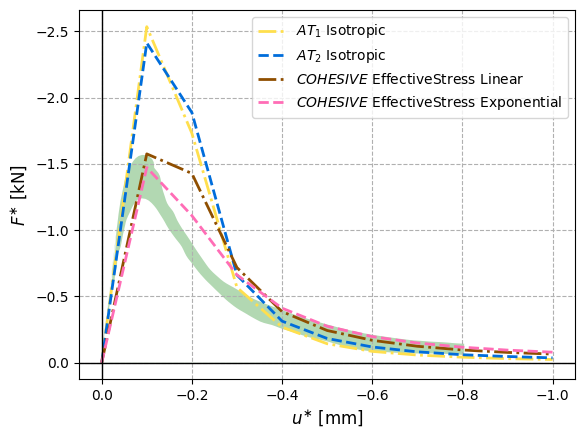

In [7]:
prefixes = [
    "AT1_Isotropic",
    "AT2_Isotropic",
    "COHESIVE_EffectiveStress_Linear",
    "COHESIVE_EffectiveStress_Exponential",
]
labels = [
    r"${AT}_1$ Isotropic",
    r"${AT}_2$ Isotropic",
    r"${COHESIVE}$ EffectiveStress Linear",
    r"${COHESIVE}$ EffectiveStress Exponential",
]
ls = ["-.", "--", ".", "-"]
colors = ["#ffdf4d", "#006ddb", "#8f4e00", "#ff6db6"]

fig, ax = plt.subplots()
for i, pre in enumerate(prefixes):
    pvd = f"{output_dir}/{pre}.pvd"
    if Path(pvd).is_file():
        curve = force_displ_from_pvd(pvd)
        plt.plot(
            curve[1],
            curve[0],
            ls[i % 2],
            label=labels[i],
            linewidth=2,
            color=colors[i],
            alpha=1,
        )

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
ax.grid(linestyle="dashed")
ax.set_xlabel("$u^{\\ast}$ [mm]", fontsize=12)
ax.set_ylabel("$F^{\\ast}$ [kN]", fontsize=12)
plt.xlim(plt.xlim()[::-1])
plt.ylim(plt.ylim()[::-1])
plt.legend(ncol=1)
ax.axhline(y=0, color="black", linewidth=1)
ax.axvline(x=0, color="black", linewidth=1)
plt.fill_between(
    data_upper.iloc[:, 0], 0, data_upper.iloc[:, 1], facecolor="green", alpha=0.3
)
plt.fill_between(
    data_lower.iloc[:, 0], 0, data_lower.iloc[:, 1], facecolor="white", alpha=1
)

Running all the selected cases with fine time steps (100 steps) yields the following figure in which the green patch bounds the experimental data. The cohesive models match the experimental results better than $\texttt{AT}_1$ and $\texttt{AT}_2$. 

![Results](./figures/F_vs_u.png "Results")